# News Recomendation System

`Rio Armiga`

## Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from nltk.stem.porter import PorterStemmer
#count vectorizor
from sklearn.feature_extraction.text import CountVectorizer
#cosine similarties to calculate the similarty measure between news category
from sklearn.metrics.pairwise import cosine_similarity

## Read Data

In [2]:
df = pd.read_csv("final data.csv")
df.head()

,Unnamed: 0,viewers_id,content_id,hit_timestamp,user_type,category_id,tagging,creator_id,category_name,viewers_birthdate,viewers_gender,viewers_region
0,0,UN-RY8dNmQ,OC0RuX,2022-07-30,Anonymus User,23.0,"[{""tag_id"": ""l33saH"", ""tag_name"": ""nathalie-ho...",99jY83,Hiburan,NaN,NaN,NaN
1,1,UN-RY8dNmQ,OC0RuX,2022-07-30,Anonymus User,23.0,"[{""tag_id"": ""l33saH"", ""tag_name"": ""nathalie-ho...",99jY83,Hiburan,NaN,NaN,NaN
2,2,UN-b1g5Cc6,EsWkCd,2022-07-31,Anonymus User,23.0,"[{""tag_id"": ""Tw9Th4"", ""tag_name"": ""deddy-corbu...",99jY83,Hiburan,NaN,NaN,NaN
3,3,UN-b1g5Cc6,EsWkCd,2022-07-31,Anonymus User,23.0,"[{""tag_id"": ""Tw9Th4"", ""tag_name"": ""deddy-corbu...",99jY83,Hiburan,NaN,NaN,NaN
4,4,UN-kNqX0xJ,WMKZwi,2022-07-31,Anonymus User,23.0,"[{""tag_id"": ""MSDG2f"", ""tag_name"": ""valencia-ta...",99jY83,Hiburan,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958547 entries, 0 to 958546
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         958547 non-null  int64  
 1   viewers_id         958547 non-null  object 
 2   content_id         958547 non-null  object 
 3   hit_timestamp      958547 non-null  object 
 4   user_type          958547 non-null  object 
 5   category_id        958547 non-null  float64
 6   tagging            920275 non-null  object 
 7   creator_id         958547 non-null  object 
 8   category_name      958547 non-null  object 
 9   viewers_birthdate  4115 non-null    object 
 10  viewers_gender     4115 non-null    object 
 11  viewers_region     3988 non-null    object 
dtypes: float64(1), int64(1), object(10)
memory usage: 87.8+ MB


### Detecting Missing Value

In [4]:
def detect_missval(df):
    global df_missval
    df_missval = pd.DataFrame(columns=['col_name','missing_count','missing_percentage'])
    for i in range(len(df.columns)):
        if df.iloc[:,i].isnull().sum() != 0:
            df_missval.loc[i] = [df.columns[i], # col_name
                                df.iloc[:,i].isnull().sum(), # missing_count
                                df.iloc[:,i].isnull().sum()/len(df.iloc[:,i])*100] # missing_percentage
    print('Generate df_missval')
    return df_missval

In [5]:
# X_train Set
detect_missval(df)

Generate df_missval


,col_name,missing_count,missing_percentage
6,tagging,38272,3.992710
9,viewers_birthdate,954432,99.570704
10,viewers_gender,954432,99.570704
11,viewers_region,954559,99.583954


Melihat isi dari kolom tagging

In [6]:
tag_0 = df['tagging'][0]
data = json.loads(tag_0)
data

[{'tag_id': 'l33saH',
  'tag_name': 'nathalie-holscher',
  'tag_slug': 'nathalie-holscher',
  'status': 1,
  'created': {'$date': '2021-11-22T02:32:04.404Z'},
  'updateat': {'$date': '0001-01-03T00:00:00.000Z'},
  'backgroundimage': '',
  'tumbimage': '',
  'source': 2},
 {'tag_id': 'n3X0Hm',
  'tag_name': 'sidang-cerai-nathalie-holscher',
  'tag_slug': 'sidang-cerai-nathalie-holscher',
  'status': 1,
  'created': {'$date': '2022-07-15T08:40:23.444Z'},
  'updateat': {'$date': '0001-01-03T00:00:00.000Z'},
  'backgroundimage': '',
  'tumbimage': '',
  'source': 2},
 {'tag_id': 'EiUKlV',
  'tag_name': 'perceraian-nathalie-holscher',
  'tag_slug': 'perceraian-nathalie-holscher',
  'status': 1,
  'created': {'$date': '2022-07-07T04:15:45.332Z'},
  'updateat': {'$date': '0001-01-03T00:00:00.000Z'},
  'backgroundimage': '',
  'tumbimage': '',
  'source': 2},
 {'tag_id': 'eK7aRP',
  'tag_name': 'sule',
  'tag_slug': 'sule',
  'status': 1,
  'created': {'$date': '2022-07-18T23:53:06.557Z'},
  '

In [7]:
print(type(data))

<class 'list'>


In [8]:
print(data[1])

{'tag_id': 'n3X0Hm', 'tag_name': 'sidang-cerai-nathalie-holscher', 'tag_slug': 'sidang-cerai-nathalie-holscher', 'status': 1, 'created': {'$date': '2022-07-15T08:40:23.444Z'}, 'updateat': {'$date': '0001-01-03T00:00:00.000Z'}, 'backgroundimage': '', 'tumbimage': '', 'source': 2}


Melakukan ekstraksi tag_name

In [9]:
y = []

for i in data:
    y.append(i['tag_name'])

In [10]:
y

['nathalie-holscher',
 'sidang-cerai-nathalie-holscher',
 'perceraian-nathalie-holscher',
 'sule',
 'nathalie-holscher-dan-sule']

In [11]:
tagging = df['tagging'].values.tolist()


In [12]:
print(type(tagging))

<class 'list'>


In [13]:
df0 = pd.DataFrame.from_dict(tagging)
print(df0)

                                                        0
0       [{"tag_id": "l33saH", "tag_name": "nathalie-ho...
1       [{"tag_id": "l33saH", "tag_name": "nathalie-ho...
2       [{"tag_id": "Tw9Th4", "tag_name": "deddy-corbu...
3       [{"tag_id": "Tw9Th4", "tag_name": "deddy-corbu...
4       [{"tag_id": "MSDG2f", "tag_name": "valencia-ta...
...                                                   ...
958542                                                NaN
958543                                                NaN
958544                                                NaN
958545  [{"tag_id": "D5mK4C", "tag_name": "dunia-polit...
958546  [{"tag_id": "D5mK4C", "tag_name": "dunia-polit...

[958547 rows x 1 columns]


In [14]:
jsonString = json.dumps(tagging)

In [15]:
print(type(jsonString))

<class 'str'>


In [16]:
data_tag = json.loads(jsonString)
data_tag

['[{"tag_id": "l33saH", "tag_name": "nathalie-holscher", "tag_slug": "nathalie-holscher", "status": 1, "created": {"$date": "2021-11-22T02:32:04.404Z"}, "updateat": {"$date": "0001-01-03T00:00:00.000Z"}, "backgroundimage": "", "tumbimage": "", "source": 2}, {"tag_id": "n3X0Hm", "tag_name": "sidang-cerai-nathalie-holscher", "tag_slug": "sidang-cerai-nathalie-holscher", "status": 1, "created": {"$date": "2022-07-15T08:40:23.444Z"}, "updateat": {"$date": "0001-01-03T00:00:00.000Z"}, "backgroundimage": "", "tumbimage": "", "source": 2}, {"tag_id": "EiUKlV", "tag_name": "perceraian-nathalie-holscher", "tag_slug": "perceraian-nathalie-holscher", "status": 1, "created": {"$date": "2022-07-07T04:15:45.332Z"}, "updateat": {"$date": "0001-01-03T00:00:00.000Z"}, "backgroundimage": "", "tumbimage": "", "source": 2}, {"tag_id": "eK7aRP", "tag_name": "sule", "tag_slug": "sule", "status": 1, "created": {"$date": "2022-07-18T23:53:06.557Z"}, "updateat": {"$date": "0001-01-03T00:00:00.000Z"}, "backgrou

In [17]:
data_tag[2]

'[{"tag_id": "Tw9Th4", "tag_name": "deddy-corbuzier", "tag_slug": "deddy-corbuzier", "status": 1, "created": {"$date": "2022-06-29T23:59:11.912Z"}, "updateat": {"$date": "0001-01-03T00:00:00.000Z"}, "backgroundimage": "", "tumbimage": "", "source": 2}, {"tag_id": "1WxNeW", "tag_name": "vicky-prasetyo", "tag_slug": "vicky-prasetyo", "status": 1, "created": {"$date": "2021-09-10T08:02:24.347Z"}, "updateat": {"$date": "0001-01-03T00:00:00.000Z"}, "backgroundimage": "https://img.inews.co.id/media/800/files/inews_new/2021/09/09/vicky_prasetyo_ditemani_istri_dan_ibunda.jpeg", "tumbimage": "https://img.inews.co.id/media/800/files/inews_new/2021/09/09/vicky_prasetyo_ditemani_istri_dan_ibunda.jpeg", "source": 3}, {"tag_id": "KDCqws", "tag_name": "kekayaan-deddy-corbuzier", "tag_slug": "kekayaan-deddy-corbuzier", "status": 1, "created": {"$date": "2022-06-17T07:57:38.437Z"}, "updateat": {"$date": "0001-01-03T00:00:00.000Z"}, "backgroundimage": "", "tumbimage": "", "source": 2}, {"tag_id": "x8pUc

In [18]:
df_tag = pd.DataFrame(tagging, columns=['tag'] )
df_tag

,tag
0,"[{""tag_id"": ""l33saH"", ""tag_name"": ""nathalie-ho..."
1,"[{""tag_id"": ""l33saH"", ""tag_name"": ""nathalie-ho..."
2,"[{""tag_id"": ""Tw9Th4"", ""tag_name"": ""deddy-corbu..."
3,"[{""tag_id"": ""Tw9Th4"", ""tag_name"": ""deddy-corbu..."
4,"[{""tag_id"": ""MSDG2f"", ""tag_name"": ""valencia-ta..."
...,...
958542,NaN
958543,NaN
958544,NaN
958545,"[{""tag_id"": ""D5mK4C"", ""tag_name"": ""dunia-polit..."


In [19]:
df_tag.tag[1]

'[{"tag_id": "l33saH", "tag_name": "nathalie-holscher", "tag_slug": "nathalie-holscher", "status": 1, "created": {"$date": "2021-11-22T02:32:04.404Z"}, "updateat": {"$date": "0001-01-03T00:00:00.000Z"}, "backgroundimage": "", "tumbimage": "", "source": 2}, {"tag_id": "n3X0Hm", "tag_name": "sidang-cerai-nathalie-holscher", "tag_slug": "sidang-cerai-nathalie-holscher", "status": 1, "created": {"$date": "2022-07-15T08:40:23.444Z"}, "updateat": {"$date": "0001-01-03T00:00:00.000Z"}, "backgroundimage": "", "tumbimage": "", "source": 2}, {"tag_id": "EiUKlV", "tag_name": "perceraian-nathalie-holscher", "tag_slug": "perceraian-nathalie-holscher", "status": 1, "created": {"$date": "2022-07-07T04:15:45.332Z"}, "updateat": {"$date": "0001-01-03T00:00:00.000Z"}, "backgroundimage": "", "tumbimage": "", "source": 2}, {"tag_id": "eK7aRP", "tag_name": "sule", "tag_slug": "sule", "status": 1, "created": {"$date": "2022-07-18T23:53:06.557Z"}, "updateat": {"$date": "0001-01-03T00:00:00.000Z"}, "backgroun

## EDA

In [20]:
df.head(2)

,Unnamed: 0,viewers_id,content_id,hit_timestamp,user_type,category_id,tagging,creator_id,category_name,viewers_birthdate,viewers_gender,viewers_region
0,0,UN-RY8dNmQ,OC0RuX,2022-07-30,Anonymus User,23.0,"[{""tag_id"": ""l33saH"", ""tag_name"": ""nathalie-ho...",99jY83,Hiburan,NaN,NaN,NaN
1,1,UN-RY8dNmQ,OC0RuX,2022-07-30,Anonymus User,23.0,"[{""tag_id"": ""l33saH"", ""tag_name"": ""nathalie-ho...",99jY83,Hiburan,NaN,NaN,NaN


In [21]:
def with_hue(ax, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in ax.patches]
    patch = [p for p in ax.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)

def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

Melihat persentase tipe pelanggan

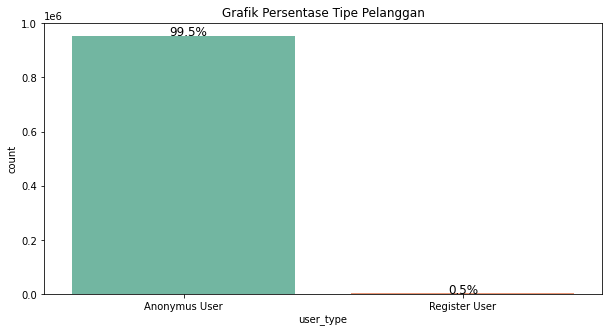

In [22]:
plt.figure(figsize=(10,5))
plt.title('Grafik Persentase Tipe Pelanggan')
ax = sns.countplot(data=df, x='user_type', palette='Set2')
without_hue(ax, df.user_type)


- sebesar 99.5% pelanggan yang mengunjungi news portal kita masih belum memiliki akun.

Melihat regional dari pembaca 

In [23]:
df.viewers_region.value_counts()

Jakarta                         1863
South Sulawesi                  1225
West Java                        401
East Java                        126
Banten                            97
West Nusa Tenggara                71
Central Java                      60
Special Region of Yogyakarta      43
Bali                              38
Bengkulu                          34
Riau Islands                      11
West Papua                         9
Papua                              4
North Sumatra                      4
Jawa Tengah                        2
Name: viewers_region, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'Jakarta'),
  Text(1, 0, 'South Sulawesi'),
  Text(2, 0, 'Bali'),
  Text(3, 0, 'North Sumatra'),
  Text(4, 0, 'Central Java'),
  Text(5, 0, 'East Java'),
  Text(6, 0, 'West Java'),
  Text(7, 0, 'Banten'),
  Text(8, 0, 'West Papua'),
  Text(9, 0, 'Riau Islands'),
  Text(10, 0, 'Bengkulu'),
  Text(11, 0, 'Papua'),
  Text(12, 0, 'Special Region of Yogyakarta'),
  Text(13, 0, 'Jawa Tengah'),
  Text(14, 0, 'West Nusa Tenggara')])

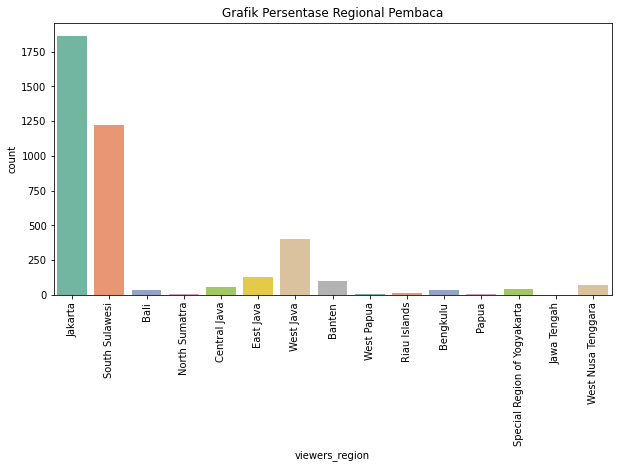

In [24]:
plt.figure(figsize=(10,5))
plt.title('Grafik Persentase Regional Pembaca')
ax = sns.countplot(data=df, x='viewers_region', palette='Set2')
# without_hue(ax, df.viewers_region)
plt.xticks(rotation=90)

- Mayoritas pembaca yang sudah memiliki akun pada news portal berasal dari jakarta dan sulawesi selatan

Melihat Persentase Kategori Berita

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Hiburan'),
  Text(1, 0, 'Wisata dan Kuliner'),
  Text(2, 0, 'Olahraga'),
  Text(3, 0, 'Gaya Hidup'),
  Text(4, 0, 'Politik & Peristiwa'),
  Text(5, 0, 'Kebijakan Publik'),
  Text(6, 0, 'Teknologi'),
  Text(7, 0, 'Keuangan dan Bisnis'),
  Text(8, 0, 'Luxury'),
  Text(9, 0, 'Ekonomi'),
  Text(10, 0, 'Musik dan Film'),
  Text(11, 0, 'Kesehatan'),
  Text(12, 0, 'Games'),
  Text(13, 0, 'Otomotif'),
  Text(14, 0, 'Gawai'),
  Text(15, 0, 'Kecantikan'),
  Text(16, 0, 'Budaya'),
  Text(17, 0, 'Humor')])

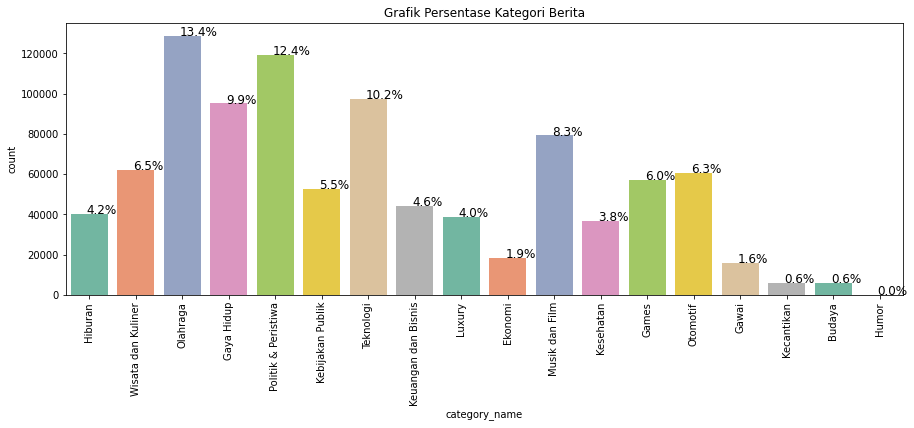

In [25]:
plt.figure(figsize=(15,5))
plt.title('Grafik Persentase Kategori Berita')
ax = sns.countplot(data=df, x='category_name', palette='Set2')
without_hue(ax, df.category_name)
plt.xticks(rotation=90)
# plt.xticks([0,1],['Tidak Berlangganan','Berlangganan'], fontsize = 11)

In [26]:
pelanggan = df[df['user_type'] == 'Register User']
pelanggan.head(2)

,Unnamed: 0,viewers_id,content_id,hit_timestamp,user_type,category_id,tagging,creator_id,category_name,viewers_birthdate,viewers_gender,viewers_region
14208,14208,HD8ZXY,7YxHCJ,2022-11-13,Register User,23.0,"[{""tag_id"": ""iLeWqd"", ""tag_name"": ""letitia-wri...",61a488153d721e2466a44341,Hiburan,2000-10-07,Female,Jakarta
14209,14209,HD8ZXY,7YxHCJ,2022-11-13,Register User,23.0,"[{""tag_id"": ""iLeWqd"", ""tag_name"": ""letitia-wri...",61a488153d721e2466a44341,Hiburan,2000-10-07,Female,Jakarta


In [27]:
print(df.viewers_id.value_counts().head(10))
print('----------'*5)
print(pelanggan.viewers_id.value_counts().head(10))

x88dXi        598
UN-N0TKagc    598
UN-ygTZVAM    578
UN-NbBkiDe    504
UN-uDvClNP    500
UN-RmQavEh    500
UN-1TrfE3z    500
UN-ZIpEjhi    500
UN-YMgslOX    500
UN-SG0EpZe    500
Name: viewers_id, dtype: int64
--------------------------------------------------
x88dXi    598
v5cwzy    471
KTq08K    389
ar02hG    232
cxH1CC    180
xrNW6K    170
HD8ZXY    167
GT4GVL    134
80cOae    124
0uXeuf    121
Name: viewers_id, dtype: int64


- Banyak yang pembaca berita yang sudah sering baca berita di portal berita kita namun masih belum memiliki akun di portal berita.

In [28]:
pel1 = df[df['viewers_id']=='UN-N0TKagc']
pel1

,Unnamed: 0,viewers_id,content_id,hit_timestamp,user_type,category_id,tagging,creator_id,category_name,viewers_birthdate,viewers_gender,viewers_region
51764,51764,UN-N0TKagc,1a3f534fc56f4868b740f73f4f6fa1be,2022-09-15,Anonymus User,33.0,"[{""tag_id"": ""LdiCih"", ""tag_name"": ""makanan"", ""...",F7vGdy,Wisata dan Kuliner,NaN,NaN,NaN
51778,51778,UN-N0TKagc,1a3f534fc56f4868b740f73f4f6fa1be,2022-09-15,Anonymus User,33.0,"[{""tag_id"": ""LdiCih"", ""tag_name"": ""makanan"", ""...",F7vGdy,Wisata dan Kuliner,NaN,NaN,NaN
51779,51779,UN-N0TKagc,1a3f534fc56f4868b740f73f4f6fa1be,2022-09-15,Anonymus User,33.0,"[{""tag_id"": ""LdiCih"", ""tag_name"": ""makanan"", ""...",F7vGdy,Wisata dan Kuliner,NaN,NaN,NaN
51780,51780,UN-N0TKagc,1a3f534fc56f4868b740f73f4f6fa1be,2022-09-15,Anonymus User,33.0,"[{""tag_id"": ""LdiCih"", ""tag_name"": ""makanan"", ""...",F7vGdy,Wisata dan Kuliner,NaN,NaN,NaN
51781,51781,UN-N0TKagc,1a3f534fc56f4868b740f73f4f6fa1be,2022-09-15,Anonymus User,33.0,"[{""tag_id"": ""LdiCih"", ""tag_name"": ""makanan"", ""...",F7vGdy,Wisata dan Kuliner,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
944351,944351,UN-N0TKagc,618ecafed0ac489c994b6d2a67836e02,2022-09-15,Anonymus User,32.0,"[{""tag_id"": ""QILrOA"", ""tag_name"": ""samsung"", ""...",F7vGdy,Gawai,NaN,NaN,NaN
944352,944352,UN-N0TKagc,618ecafed0ac489c994b6d2a67836e02,2022-09-15,Anonymus User,32.0,"[{""tag_id"": ""QILrOA"", ""tag_name"": ""samsung"", ""...",F7vGdy,Gawai,NaN,NaN,NaN
948999,948999,UN-N0TKagc,6b4796f69bdf4d8893282da15ebce17c,2022-09-15,Anonymus User,25.0,"[{""tag_id"": ""HvV86p"", ""tag_name"": ""skincare"", ...",F7vGdy,Kecantikan,NaN,NaN,NaN
949041,949041,UN-N0TKagc,6b4796f69bdf4d8893282da15ebce17c,2022-09-15,Anonymus User,25.0,"[{""tag_id"": ""HvV86p"", ""tag_name"": ""skincare"", ...",F7vGdy,Kecantikan,NaN,NaN,NaN


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Wisata dan Kuliner'),
  Text(1, 0, 'Olahraga'),
  Text(2, 0, 'Gaya Hidup'),
  Text(3, 0, 'Politik & Peristiwa'),
  Text(4, 0, 'Teknologi'),
  Text(5, 0, 'Keuangan dan Bisnis'),
  Text(6, 0, 'Luxury'),
  Text(7, 0, 'Musik dan Film'),
  Text(8, 0, 'Otomotif'),
  Text(9, 0, 'Gawai'),
  Text(10, 0, 'Kecantikan')])

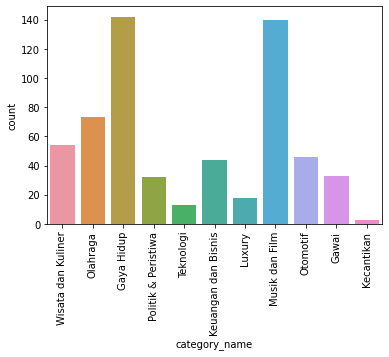

In [29]:
sns.countplot(data=pel1, x='category_name')
plt.xticks(rotation=90)

## Data Preprocessing

In [30]:
df.head(2)

,Unnamed: 0,viewers_id,content_id,hit_timestamp,user_type,category_id,tagging,creator_id,category_name,viewers_birthdate,viewers_gender,viewers_region
0,0,UN-RY8dNmQ,OC0RuX,2022-07-30,Anonymus User,23.0,"[{""tag_id"": ""l33saH"", ""tag_name"": ""nathalie-ho...",99jY83,Hiburan,NaN,NaN,NaN
1,1,UN-RY8dNmQ,OC0RuX,2022-07-30,Anonymus User,23.0,"[{""tag_id"": ""l33saH"", ""tag_name"": ""nathalie-ho...",99jY83,Hiburan,NaN,NaN,NaN


In [31]:
df.columns

Index(['Unnamed: 0', 'viewers_id', 'content_id', 'hit_timestamp', 'user_type',
       'category_id', 'tagging', 'creator_id', 'category_name',
       'viewers_birthdate', 'viewers_gender', 'viewers_region'],
      dtype='object')

In [32]:
'viewers_id','content_id','category_name'

('viewers_id', 'content_id', 'category_name')

In [33]:
df_clean = df.drop(['Unnamed: 0', 'hit_timestamp', 'user_type',
       'category_id', 'tagging', 'creator_id', 
       'viewers_birthdate', 'viewers_gender', 'viewers_region'], axis=1)

In [34]:
df_clean

,viewers_id,content_id,category_name
0,UN-RY8dNmQ,OC0RuX,Hiburan
1,UN-RY8dNmQ,OC0RuX,Hiburan
2,UN-b1g5Cc6,EsWkCd,Hiburan
3,UN-b1g5Cc6,EsWkCd,Hiburan
4,UN-kNqX0xJ,WMKZwi,Hiburan
...,...,...,...
958542,KTq08K,1BZ98E,Humor
958543,UN-eRISZYj,1BZ98E,Humor
958544,KTq08K,1BZ98E,Humor
958545,UN-DHiHLsN,bDrGRd,Humor


### Handling Missing Value

In [35]:
def detect_missval(df):
    global df_missval
    df_missval = pd.DataFrame(columns=['col_name','missing_count','missing_percentage'])
    for i in range(len(df.columns)):
        if df.iloc[:,i].isnull().sum() != 0:
            df_missval.loc[i] = [df.columns[i], # col_name
                                df.iloc[:,i].isnull().sum(), # missing_count
                                df.iloc[:,i].isnull().sum()/len(df.iloc[:,i])*100] # missing_percentage
    print('Generate df_missval')
    return df_missval



In [36]:
detect_missval(df_clean)

Generate df_missval


,col_name,missing_count,missing_percentage


- Tidak terdapat lagi missing value pada dataframe clean.

### Encoding

In [37]:
cv = CountVectorizer(max_features=100)
vectors = cv.fit_transform(df_clean['category_name']).toarray()

In [38]:
vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [39]:
vectors[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int64)

In [40]:
cv.get_feature_names()

c:\Users\rioar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['bisnis',
 'budaya',
 'dan',
 'ekonomi',
 'film',
 'games',
 'gawai',
 'gaya',
 'hiburan',
 'hidup',
 'humor',
 'kebijakan',
 'kecantikan',
 'kesehatan',
 'keuangan',
 'kuliner',
 'luxury',
 'musik',
 'olahraga',
 'otomotif',
 'peristiwa',
 'politik',
 'publik',
 'teknologi',
 'wisata']

In [41]:
similarity = cosine_similarity(vectors)

MemoryError: Unable to allocate 6.69 TiB for an array with shape (958547, 958547) and data type float64

- kekurangan resource untuk melakukan eksekusi kode.

In [ ]:
def recommend(news):
    #news_index = new_df[new_df['title'] == news].index[0]
    news_list = df_clean[df_clean['category_name'].str.contains(news)]
    if len(news_list):  
        news_idx= news_list.index[0]
        distances = similarity[news_idx]
        newss_list = sorted(list(enumerate(distances)),reverse=True, key=lambda x:x[1])[1:6]
    
        #
        print('Recommendations for {0} :\n'.format(news_list.iloc[0]['title']))
        for i in newss_list:
            print(df.iloc[i[0]].title)
    else:
        return "No newss found. Please check your input"

In [ ]:
recommend('Humor') 

NameError: name 'similarity' is not defined

### Kesimpulan

- Banyak sekali pelanggan yang belum memiliki akun di portal berita, padahal sudah sering membaca berita di portal berita ini.
- Memberikan tawaran kepada pelanggan yang belum memiliki akun agar dapat mendaftakan dirinya ke portal berita sehingga bisa mendapatkan data pelanggan yang lebih lengkap dan bisa membuat recomendation system yang lebih akurat
- Rekomendation system belum berhasil dibuat dengan cosine similarity karena kekurangan resource memory untuk melakukan eksekusi kode, kedepannya bisa menggunakan metode lain untuk membangun sistem rekomendasi berita. 